In [20]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#X_train = np.expand_dims(X_train, 3)
#X_test = np.expand_dims(X_test, 3)



In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [23]:
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=2, validation_data=(X_test, y_test))

Epoch 1/200
782/782 - 9s - loss: 3.5301 - accuracy: 0.1577 - val_loss: 2.1296 - val_accuracy: 0.2058 - 9s/epoch - 12ms/step
Epoch 2/200
782/782 - 8s - loss: 2.0223 - accuracy: 0.2544 - val_loss: 1.9257 - val_accuracy: 0.2860 - 8s/epoch - 10ms/step
Epoch 3/200
782/782 - 8s - loss: 1.8530 - accuracy: 0.3126 - val_loss: 1.7206 - val_accuracy: 0.3641 - 8s/epoch - 10ms/step
Epoch 4/200
782/782 - 8s - loss: 1.6803 - accuracy: 0.3873 - val_loss: 1.6190 - val_accuracy: 0.4103 - 8s/epoch - 10ms/step
Epoch 5/200
782/782 - 7s - loss: 1.5572 - accuracy: 0.4389 - val_loss: 1.6375 - val_accuracy: 0.4212 - 7s/epoch - 10ms/step
Epoch 6/200
782/782 - 8s - loss: 1.4561 - accuracy: 0.4799 - val_loss: 1.4080 - val_accuracy: 0.4954 - 8s/epoch - 10ms/step
Epoch 7/200
782/782 - 8s - loss: 1.3812 - accuracy: 0.5088 - val_loss: 1.4144 - val_accuracy: 0.5006 - 8s/epoch - 10ms/step
Epoch 8/200
782/782 - 8s - loss: 1.3282 - accuracy: 0.5338 - val_loss: 1.3562 - val_accuracy: 0.5193 - 8s/epoch - 10ms/step
Epoch 9/

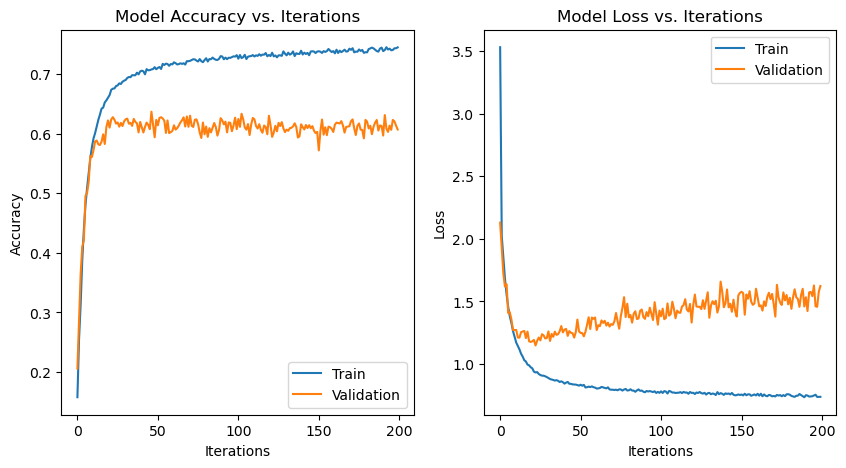

In [24]:
import matplotlib.pyplot as plt

figures, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy vs. Iterations')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Iterations')
axes[0].legend(['Train', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss vs. Iterations')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Iterations')
axes[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [25]:
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.ResNet50(input_shape=X_train[0].shape, include_top=False, weights='imagenet')

In [26]:
# image_batch, label_batch = next(iter())
# feature_batch = base_model()
# print(feature_batch.shape)

In [27]:
# base_model.trainable = False
# base_model.summary()

In [28]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)